## Learning Objectives:
1. [A Step-by-Step Illulstration of Hard-Margin SVMs](#A-Step-by-Step-Illulstration-of-Hard-Margin-SVMs)
  - [Step1: Loading a Linearly Separable Dataset](#Step1:-Loading-a-Linearly-Separable-Dataset)
  - [Training Step: Margin Maximization](#Training-Step:-Margin-Maximization)
  - [Training Step: Identify Support Vectors](#Training-Step:-Identify-Support-Vectors)
  - [Inference Step: Prediction using Support Vectors](#Inference-Step:-Prediction-using-Support-Vectors)
  - [Examine Support Vectors](#Examine-Support-Vectors)
2. [A Step-by-Step Illulstration of Soft-Margin SVMs](#A-Step-by-Step-Illulstration-of-Hard-Margin-SVMs)
  - [Step1: Loading a Non-Linearly Separable Dataset](#Step1:-Loading-a-Non-Linearly-Separable-Dataset)
  - [Training Step: Small and Large Misclassification Penalty $C$](#Training-Step:-Small-and-Large-Misclassification-Penalty-$C$)
  - [Inference Step: Prediction using Support Vectors](#Inference-Step:-Prediction-using-Support-Vectors)
3. [Comparison of Hard/Soft-Margin SVMs using Real-World Dataset](#Comparison-of-Hard/Soft-Margin-SVMs-using-Real-World-Dataset)
  - [Using K-fold Cross Validation to Assess Model Performance](#Using-K-fold-Cross-Validation-to-Assess-Model-Performance)
  - [Examining Learning Curves to Learn How Accuracy Changes with Varying Sample Size](#Examining-Learning-Curves-to-Learn-How-Accuracy-Changes-with-Varying-Sample-Size)
  - [Addressing Overfitting and Underfitting with Validation Curves](#Addressing-Overfitting-and-Underfitting-with-Validation-Curves)

#### Adapted from the following code repositories:
- Python Machine Learning 3rd Edition* by [Sebastian Raschka](https://sebastianraschka.com)
  - https://github.com/rasbt/python-machine-learning-book-3rd-edition
- Python Data Science Handbook by [Jake VanderPlas](https://www.oreilly.com/library/view/python-data-science/9781491912126/)
  - https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb

# A Step-by-Step Illulstration of Hard-Margin SVMs

In [26]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# To check recent matplotlib compatibility
import matplotlib
from distutils.version import LooseVersion


def plot_decision_regions(X, y, ax, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('lightblue', 'orange', 'lightgreen', 'gray', 'cyan')
    background = ('lightcyan', 'papayawhip')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    ax.contourf(xx1, xx2, Z, alpha=0.1, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    color=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        
        if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):
            ax.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')
        else:
            ax.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='none',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')   
    ax.set_xlabel('petal length [standardized]', size=16)
    ax.set_ylabel('petal width [standardized]', size=16)
    ax.legend(loc='upper left')

## Step1: Loading a Linearly Separable Dataset 

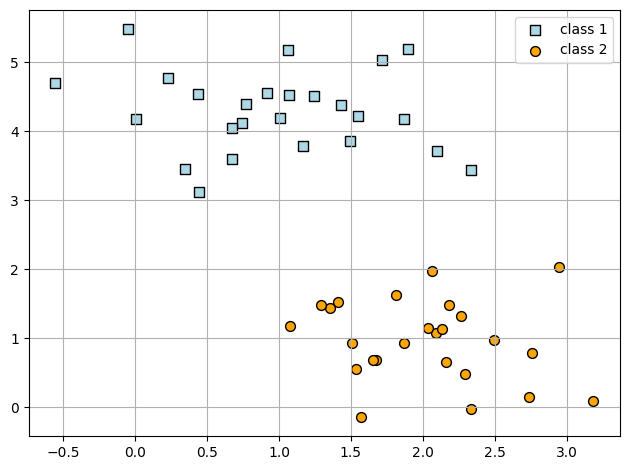

In [28]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)

plt.scatter(X[y == 0, 0],
            X[y == 0, 1],
            s=50, c='lightblue',
            marker='s', edgecolor='black',
            label='class 1')
plt.scatter(X[y == 1, 0],
            X[y == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='class 2')

plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
plt.show()

## Training Step: Margin Maximization
* The intuition of training support vector machines (SVMs) is to learn a linear hyperplan with a margin of maximum width, i.e., maximization of the distance from the linear hyperplane to the nearest point. 
* Compared against to randomly hyperplanes with a zero-width or relatively smaller width between the linear hyperplane to the nearest point. Here is an example of how both hyperplaones might look like:

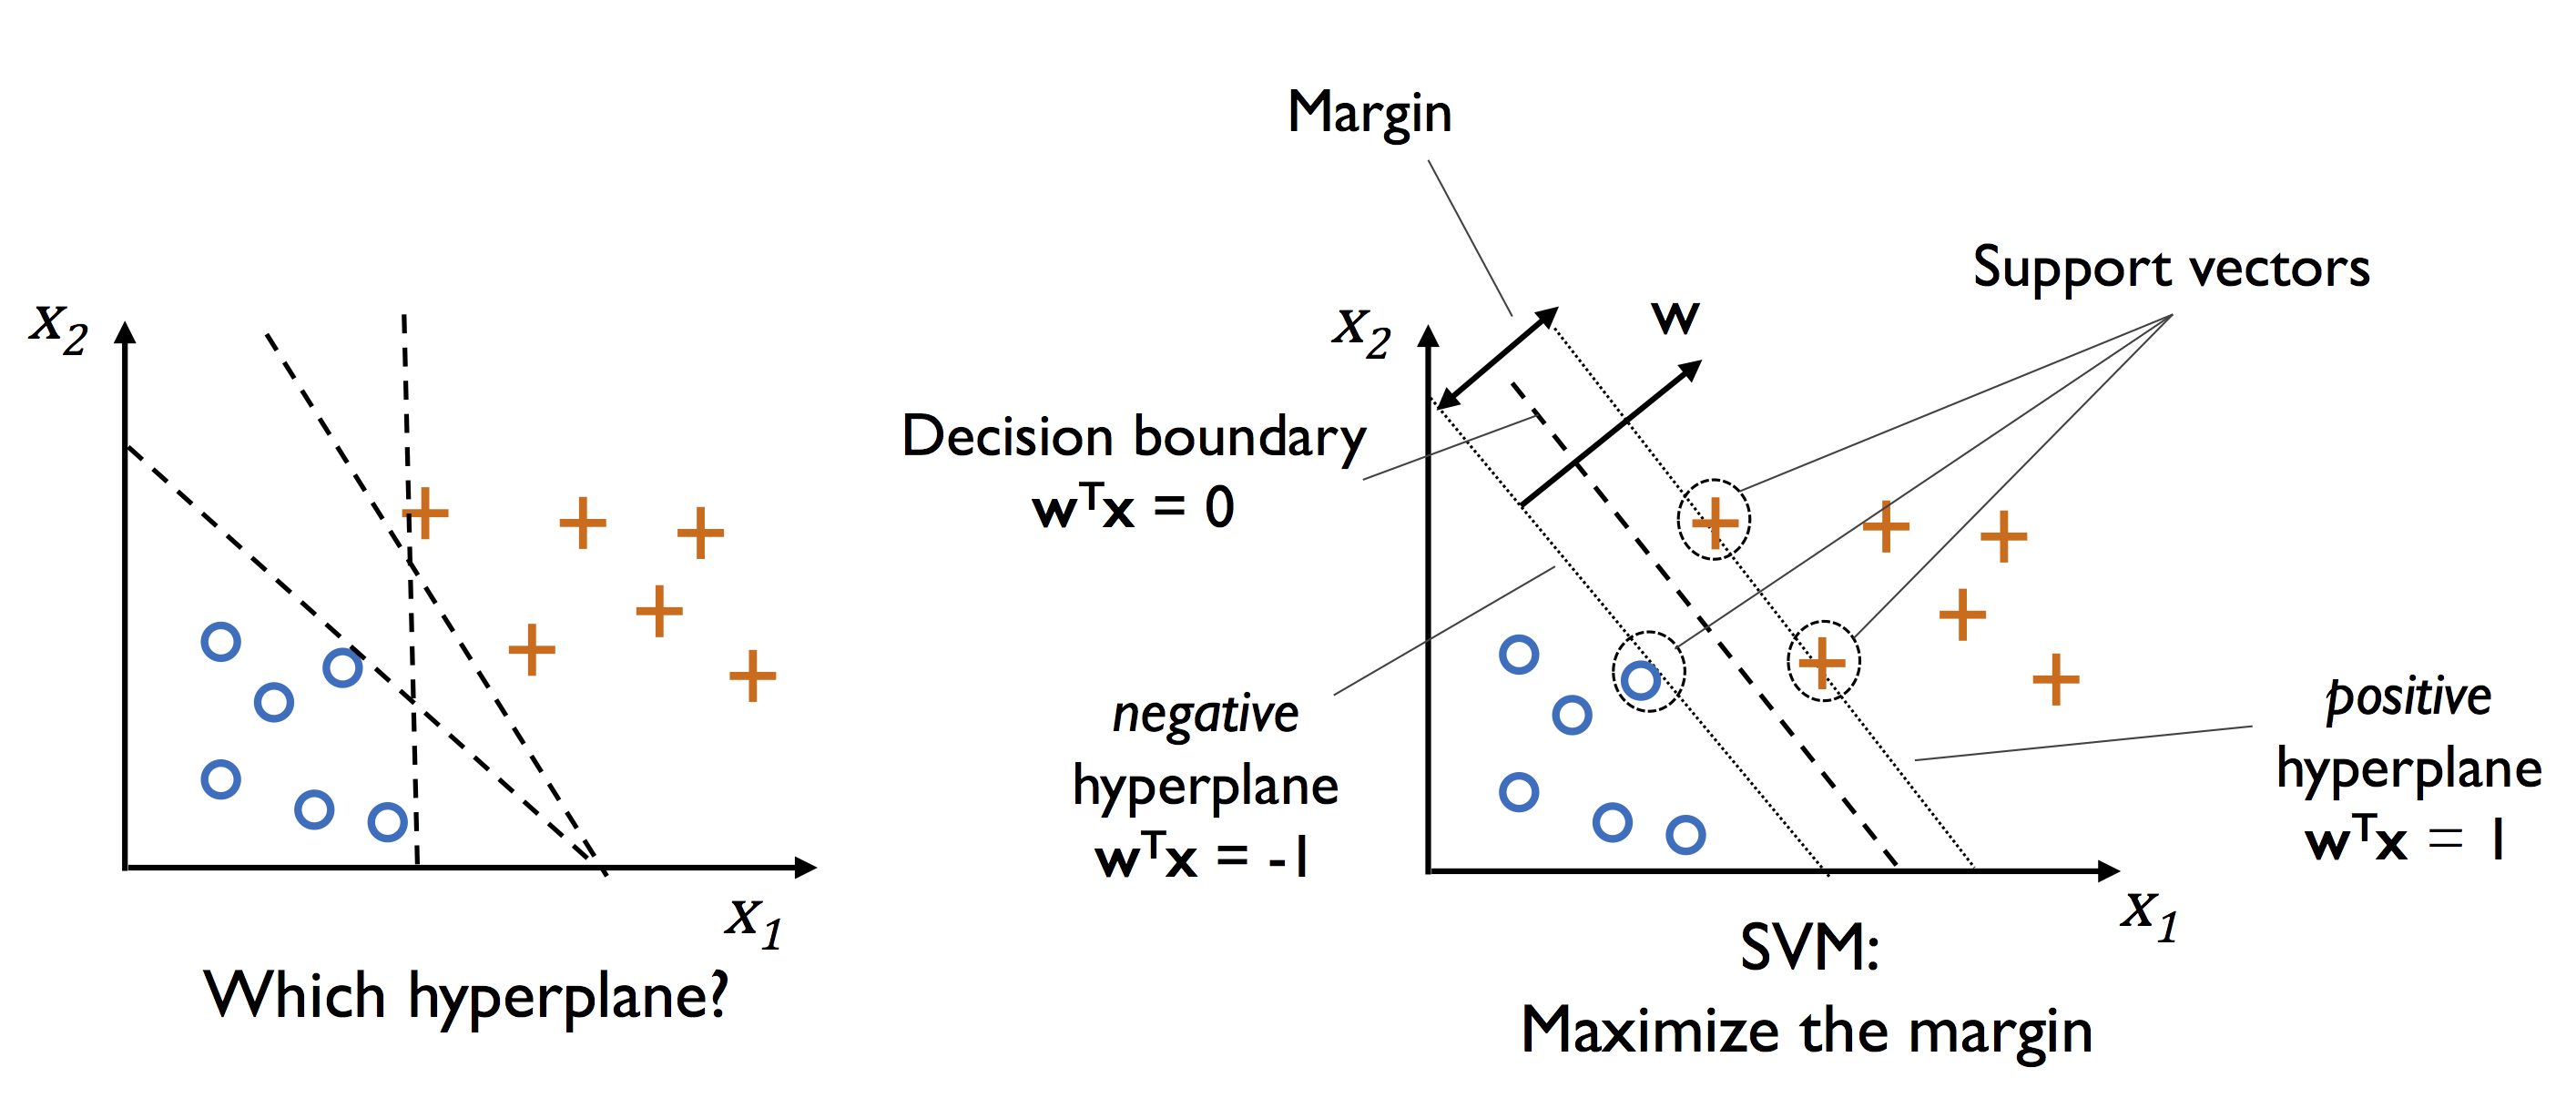

In [29]:
from IPython.display import Image
Image(filename='images/03_09.png', width=700) 

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification. For two dimensional data like that shown here, this is a task we could do by hand. However, there is more than one possible dividing line that can perfectly discriminate between the two classes as shown below. Depending on which linear hyperplane, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label! Evidently the simple intuition of "perfectly dividing line between classes" is not enough.

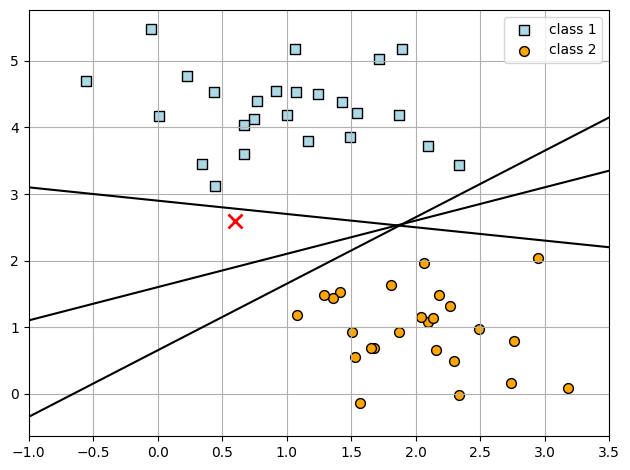

In [30]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[y == 0, 0],
            X[y == 0, 1],
            s=50, c='lightblue',
            marker='s', edgecolor='black',
            label='class 1')
plt.scatter(X[y == 1, 0],
            X[y == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='class 2')
plt.legend(scatterpoints=1)



plt.plot([0.6], [2.6], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);
plt.grid()
plt.tight_layout()
plt.show()

## Training Step: Identify Support Vectors
We will use Scikit-Learn's support vector classifier to train a hard-margin SVM model on this data. For a linearly separable dataset, we will use a linear kernel and set the $C$ parameter to an extreame large value. The in-depth discussion of the parameter $C$ will be discussed in soft-margin SVMs.

In [31]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

In [32]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # plot the decision surface
    colors = ('lightblue', 'orange', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:2])
    x1_min, x1_max = xlim[0] - 1, xlim[1] + 1
    x2_min, x2_max = ylim[0] - 1, ylim[1] + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02),
                           np.arange(x2_min, x2_max, 0.02))
    Z = model.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    ax.contourf(xx1, xx2, Z, alpha=0.1, cmap=cmap)    
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, edgecolor='black', facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

Support Vectors:
 [[0.44359863 3.11530945]
 [2.33812285 3.43116792]
 [2.06156753 1.96918596]]
Dual coefficients of the support vector in the decision function:  [[-0.2738502  -0.75147416  1.02532437]]


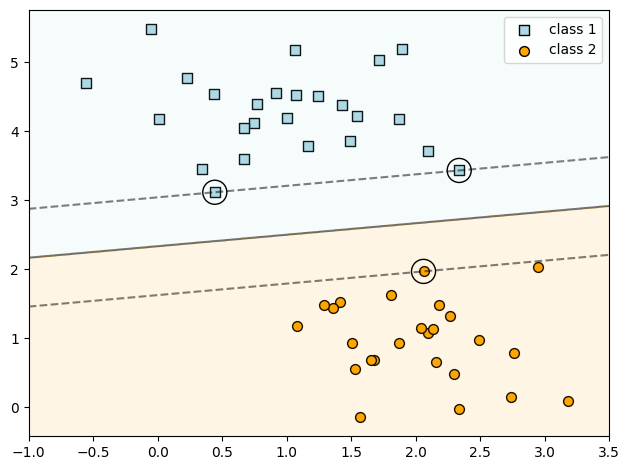

In [33]:
plt.scatter(X[y == 0, 0],
            X[y == 0, 1],
            s=50, c='lightblue',
            marker='s', edgecolor='black',
            label='class 1')
plt.scatter(X[y == 1, 0],
            X[y == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='class 2')
plt.legend(scatterpoints=1)
plt.xlim(-1, 3.5);
# plt.grid()
plt.tight_layout()

plot_svc_decision_function(model);

print( "Support Vectors:\n", model.support_vectors_)
print( "Dual coefficients of the support vector in the decision function: ", model.dual_coef_)

We have found the dividing line that maximizes the margin between the two sets of points. Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure. These points are the pivotal elements of this fit, and are known as the support vectors, and give the algorithm its name.

## Inference Step: Prediction using Support Vectors
In SVMs, only the position of the support vectors matter for prediction of new points.

Predicted Class  [0]


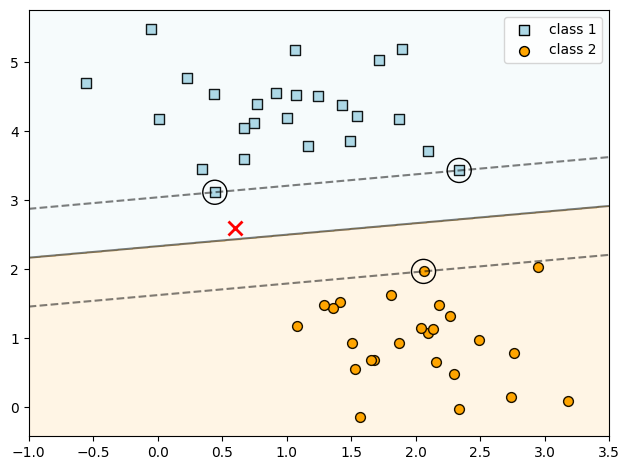

In [34]:
plt.scatter(X[y == 0, 0],
            X[y == 0, 1],
            s=50, c='lightblue',
            marker='s', edgecolor='black',
            label='class 1')
plt.scatter(X[y == 1, 0],
            X[y == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='class 2')
plt.legend(scatterpoints=1)
plt.plot([0.6], [2.6], 'x', color='red', markeredgewidth=2, markersize=10)
plt.xlim(-1, 3.5)
plt.tight_layout()
plot_svc_decision_function(model)



x = np.array([[0.6,2.6]])
print("Predicted Class ", model.predict(x))

# SV = model.support_vectors_
# W = model.dual_coef_
# c_sv1 = model.predict(np.array([SV[0].tolist()]))[0]
# c_sv2 = model.predict(np.array([SV[1].tolist()]))[0]
# c_sv3 = model.predict(np.array([SV[2].tolist()]))[0]

# print( c_sv1, c_sv2, c_sv3 )
# class_label = -1 * W[0][0] * np.matmul(x, SV[0]) + \
#               -1 * W[0][1] * np.matmul(x, SV[1]) + \
#               1 * W[0][2] * np.matmul(x, SV[2]) + model.intercept_[0]
# print( "New Instance: ", class_label)


## Examine Support Vectors
A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit! Technically, this is because these points do not contribute to the loss function used to fit the model. This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

In [35]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[y == 0, 0],
                X[y == 0, 1],
                s=50, c='lightblue',
                marker='s', edgecolor='black',
                label='class 1')
    ax.scatter(X[y == 1, 0],
                X[y == 1, 1],
                s=50, c='orange',
                marker='o', edgecolor='black',
                label='class 2')
    ax.legend(scatterpoints=1)
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

    
from ipywidgets import interact, fixed
interact(plot_svm, N=[50, 75, 100, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(50, 75, 100, 200), value=50), Output()), _dom_classes…

# A Step-by-Step Illustration of Soft-Margin SVMs

## Step1: Loading a Non-Linearly Separable Dataset

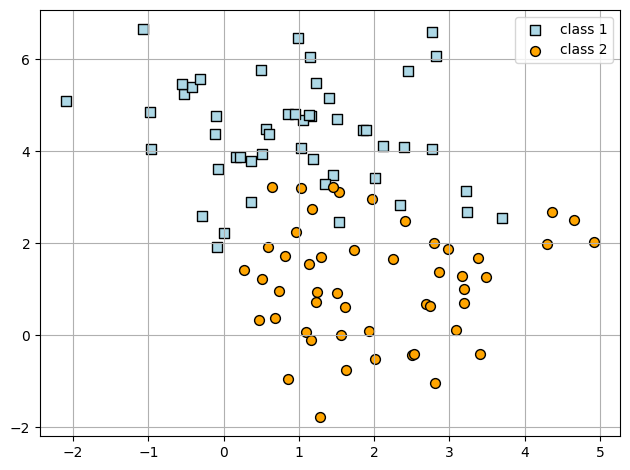

In [36]:
from sklearn.preprocessing import StandardScaler

X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[y == 0, 0],
            X[y == 0, 1],
            s=50, c='lightblue',
            marker='s', edgecolor='black',
            label='class 1')
plt.scatter(X[y == 1, 0],
            X[y == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='class 2')

plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
plt.show()


* To deal with the non-linearly separable data, we use Scikit-Learn's support vector classifier to train a soft-margin SVM model on this data using slack variables. We will use a linear kernel and set the parameter $C$ to varying values. 

* The in-depth discussion of the parameter $C$ in soft-margin SVMS is as follows:
  * Larger values of misclassification penalty $C$, the lower tolerance of misclassification errors.
  * Smaller values of misclassification penalty $C$, the higher tolerance of misclassification errors.


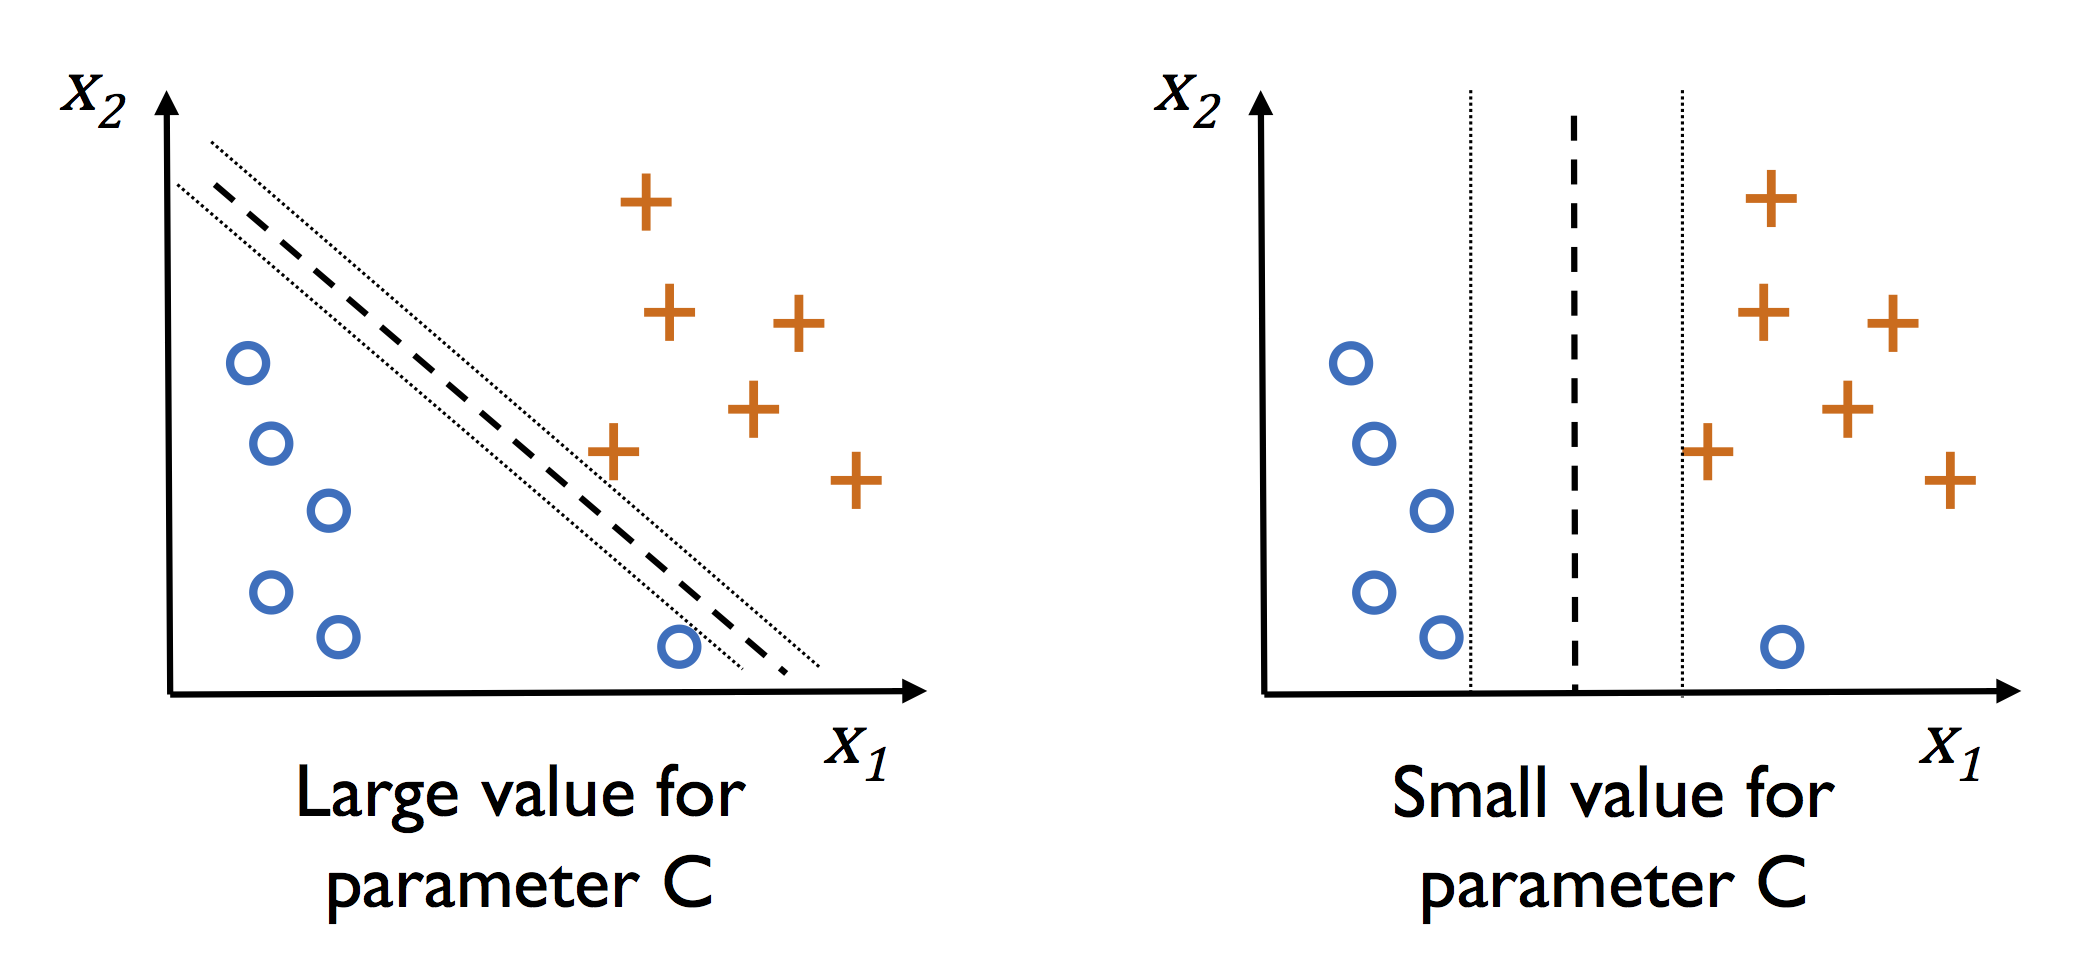

In [37]:
Image(filename='images/03_10.png', width=600) 

## Training Step: Small and Large Misclassification Penalty $C$
For very large $C$, the margin is hard, and points cannot lie in it. For smaller $C$, the margin is softer, and can grow to encompass some points.
The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit, via the softening of the margin:

/var/folders/q8/gtyqzz1155g79bwcvr1x527c0000gq/T/ipykernel_84773/1753364667.py:29: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=X[y == cl, 0],
/var/folders/q8/gtyqzz1155g79bwcvr1x527c0000gq/T/ipykernel_84773/1753364667.py:29: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=X[y == cl, 0],


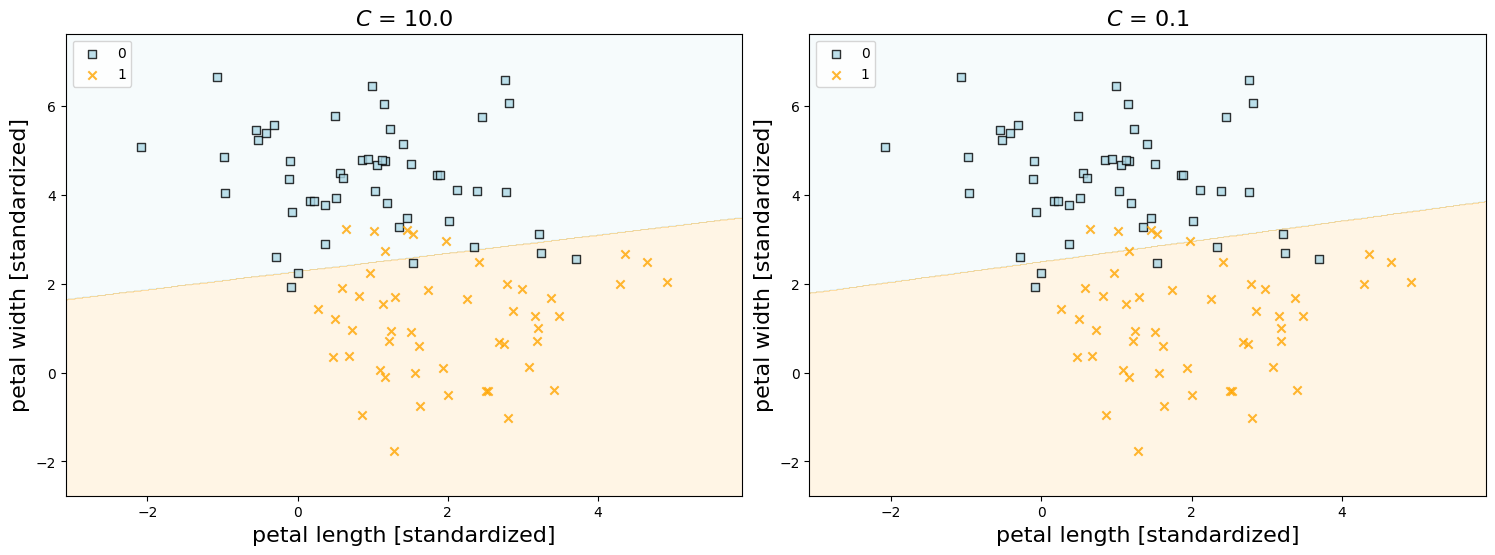

In [38]:
from sklearn.svm import SVC

#X, y = make_blobs(n_samples=100, centers=2,
#                   random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
   
    plot_decision_regions(X, y, axi, classifier=model)

    axi.set_title('$C$ = {0:.1f}'.format(C), size=16)
plt.savefig('softsvm.pdf', format='pdf')  

## Inference Step: Prediction using Support Vectors

C = 10.0,  class:  0
C = 0.1,  class:  1


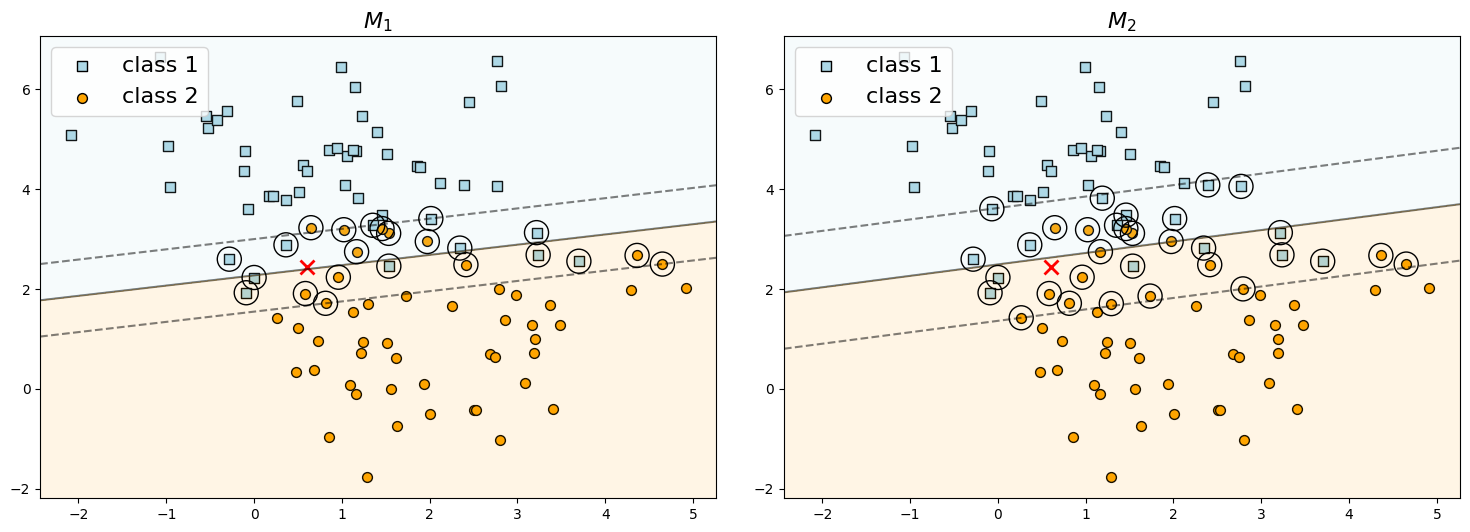

In [39]:
# X, y = make_blobs(n_samples=100, centers=2,
#                   random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

cnt=0
for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    
    axi.scatter(X[y == 0, 0],
            X[y == 0, 1],
            s=50, c='lightblue',
            marker='s', edgecolor='black',
            label='class 1')
    axi.scatter(X[y == 1, 0],
                X[y == 1, 1],
                s=50, c='orange',
                marker='o', edgecolor='black',
                label='class 2')
    axi.plot([0.6], [2.45], 'x', color='red', markeredgewidth=2, markersize=10)
    
    print('C = {0:.1f}, '.format(C), "class: ", model.predict(np.array([[0.6,2.45]]))[0])
    
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('$M_{0:.0f}$'.format(cnt+1), size=16)
    cnt+=1
    axi.legend(loc='upper left', fontsize=16)
plt.savefig('softsvm.pdf', format='pdf')

# 3. Comparison of Hard/Soft-Margin SVMs using Real-World Dataset

In [41]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

# if the Breast Cancer dataset is temporarily unavailable from the
# UCI machine learning repository, un-comment the following line
# of code to load the dataset from a local path:

# df = pd.read_csv('wdbc.data', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,...,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368
7,84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,...,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510
8,844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,...,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,...,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750


In [42]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

## Using K-fold Cross Validation to Assess Model Performance

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)


pipe_svm = make_pipeline(StandardScaler(), SVC(kernel='linear', C=10.0))

pipe_svm.fit(X_train, y_train)
y_pred = pipe_svm.predict(X_test)
print('Test Accuracy: %.3f' % pipe_svm.score(X_test, y_test))

Test Accuracy: 0.974


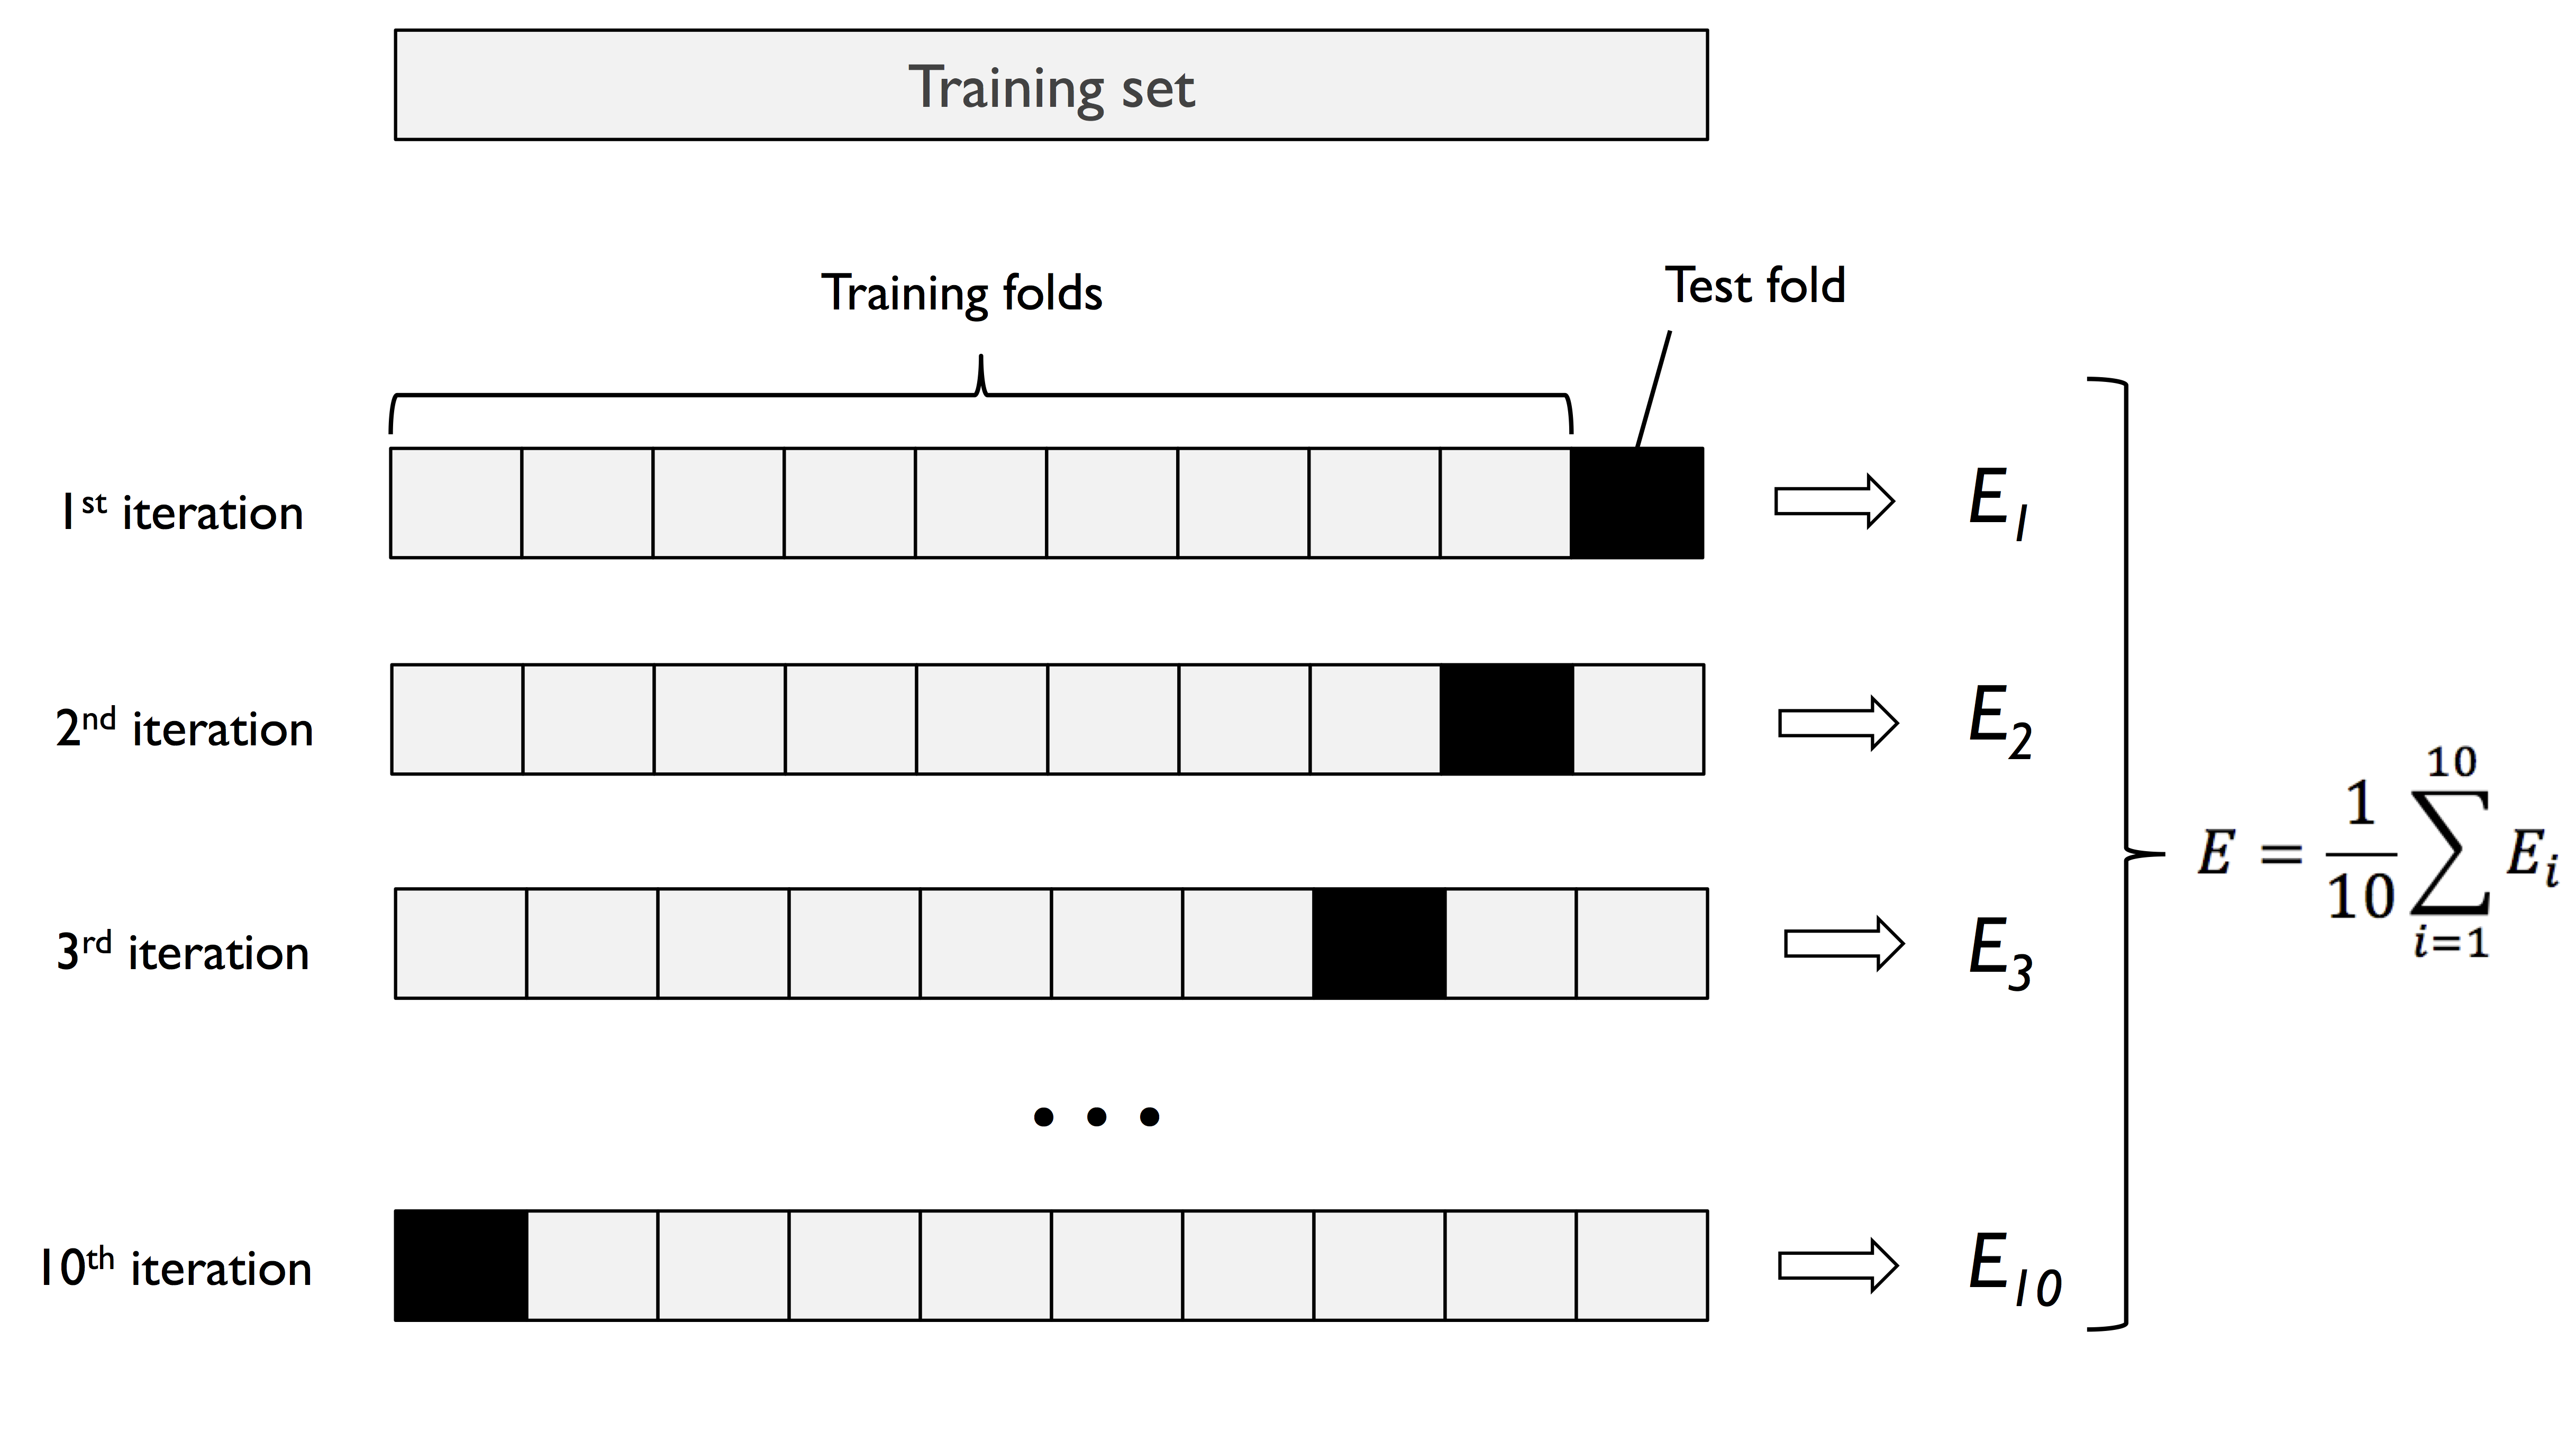

In [44]:
from IPython.display import Image
Image(filename='images/kfold.png', width=500) 

In [45]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
    

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_svm.fit(X_train[train], y_train[train])
    score = pipe_svm.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,
          np.bincount(y_train[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold:  1, Class dist.: [256 153], Acc: 0.935
Fold:  2, Class dist.: [256 153], Acc: 0.978
Fold:  3, Class dist.: [256 153], Acc: 0.978
Fold:  4, Class dist.: [256 153], Acc: 0.978
Fold:  5, Class dist.: [256 153], Acc: 0.935
Fold:  6, Class dist.: [257 153], Acc: 0.933
Fold:  7, Class dist.: [257 153], Acc: 0.978
Fold:  8, Class dist.: [257 153], Acc: 0.956
Fold:  9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 1.000

CV accuracy: 0.965 +/- 0.022


In [46]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_svm,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.93478261 0.97826087 0.97826087 0.97826087 0.93478261 0.93333333
 0.97777778 0.95555556 0.97777778 1.        ]
CV accuracy: 0.965 +/- 0.022


## Examining Learning Curves to Learn How Accuracy Changes with Varying Sample Size

In [47]:
pipe_svm.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'svc', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])

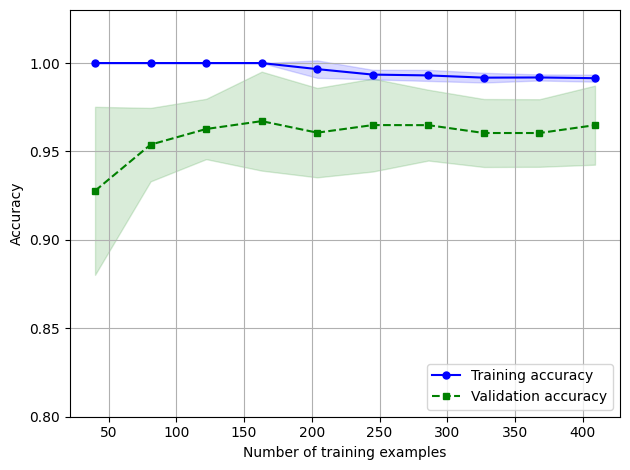

In [48]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_svm,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

## Addressing Overfitting and Underfitting with Validation Curves

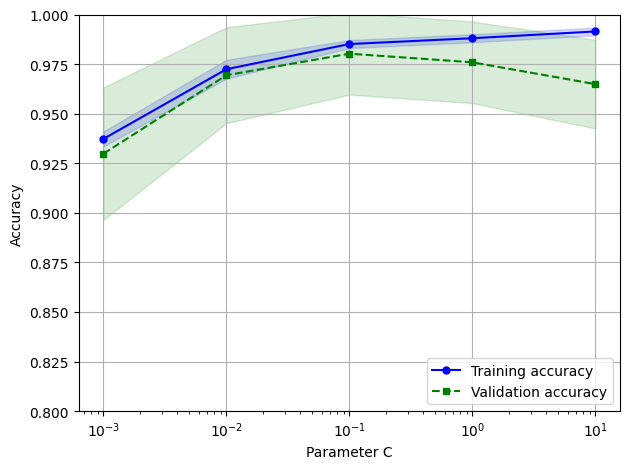

In [49]:
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_svm, 
                X=X_train, 
                y=y_train, 
                param_name='svc__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

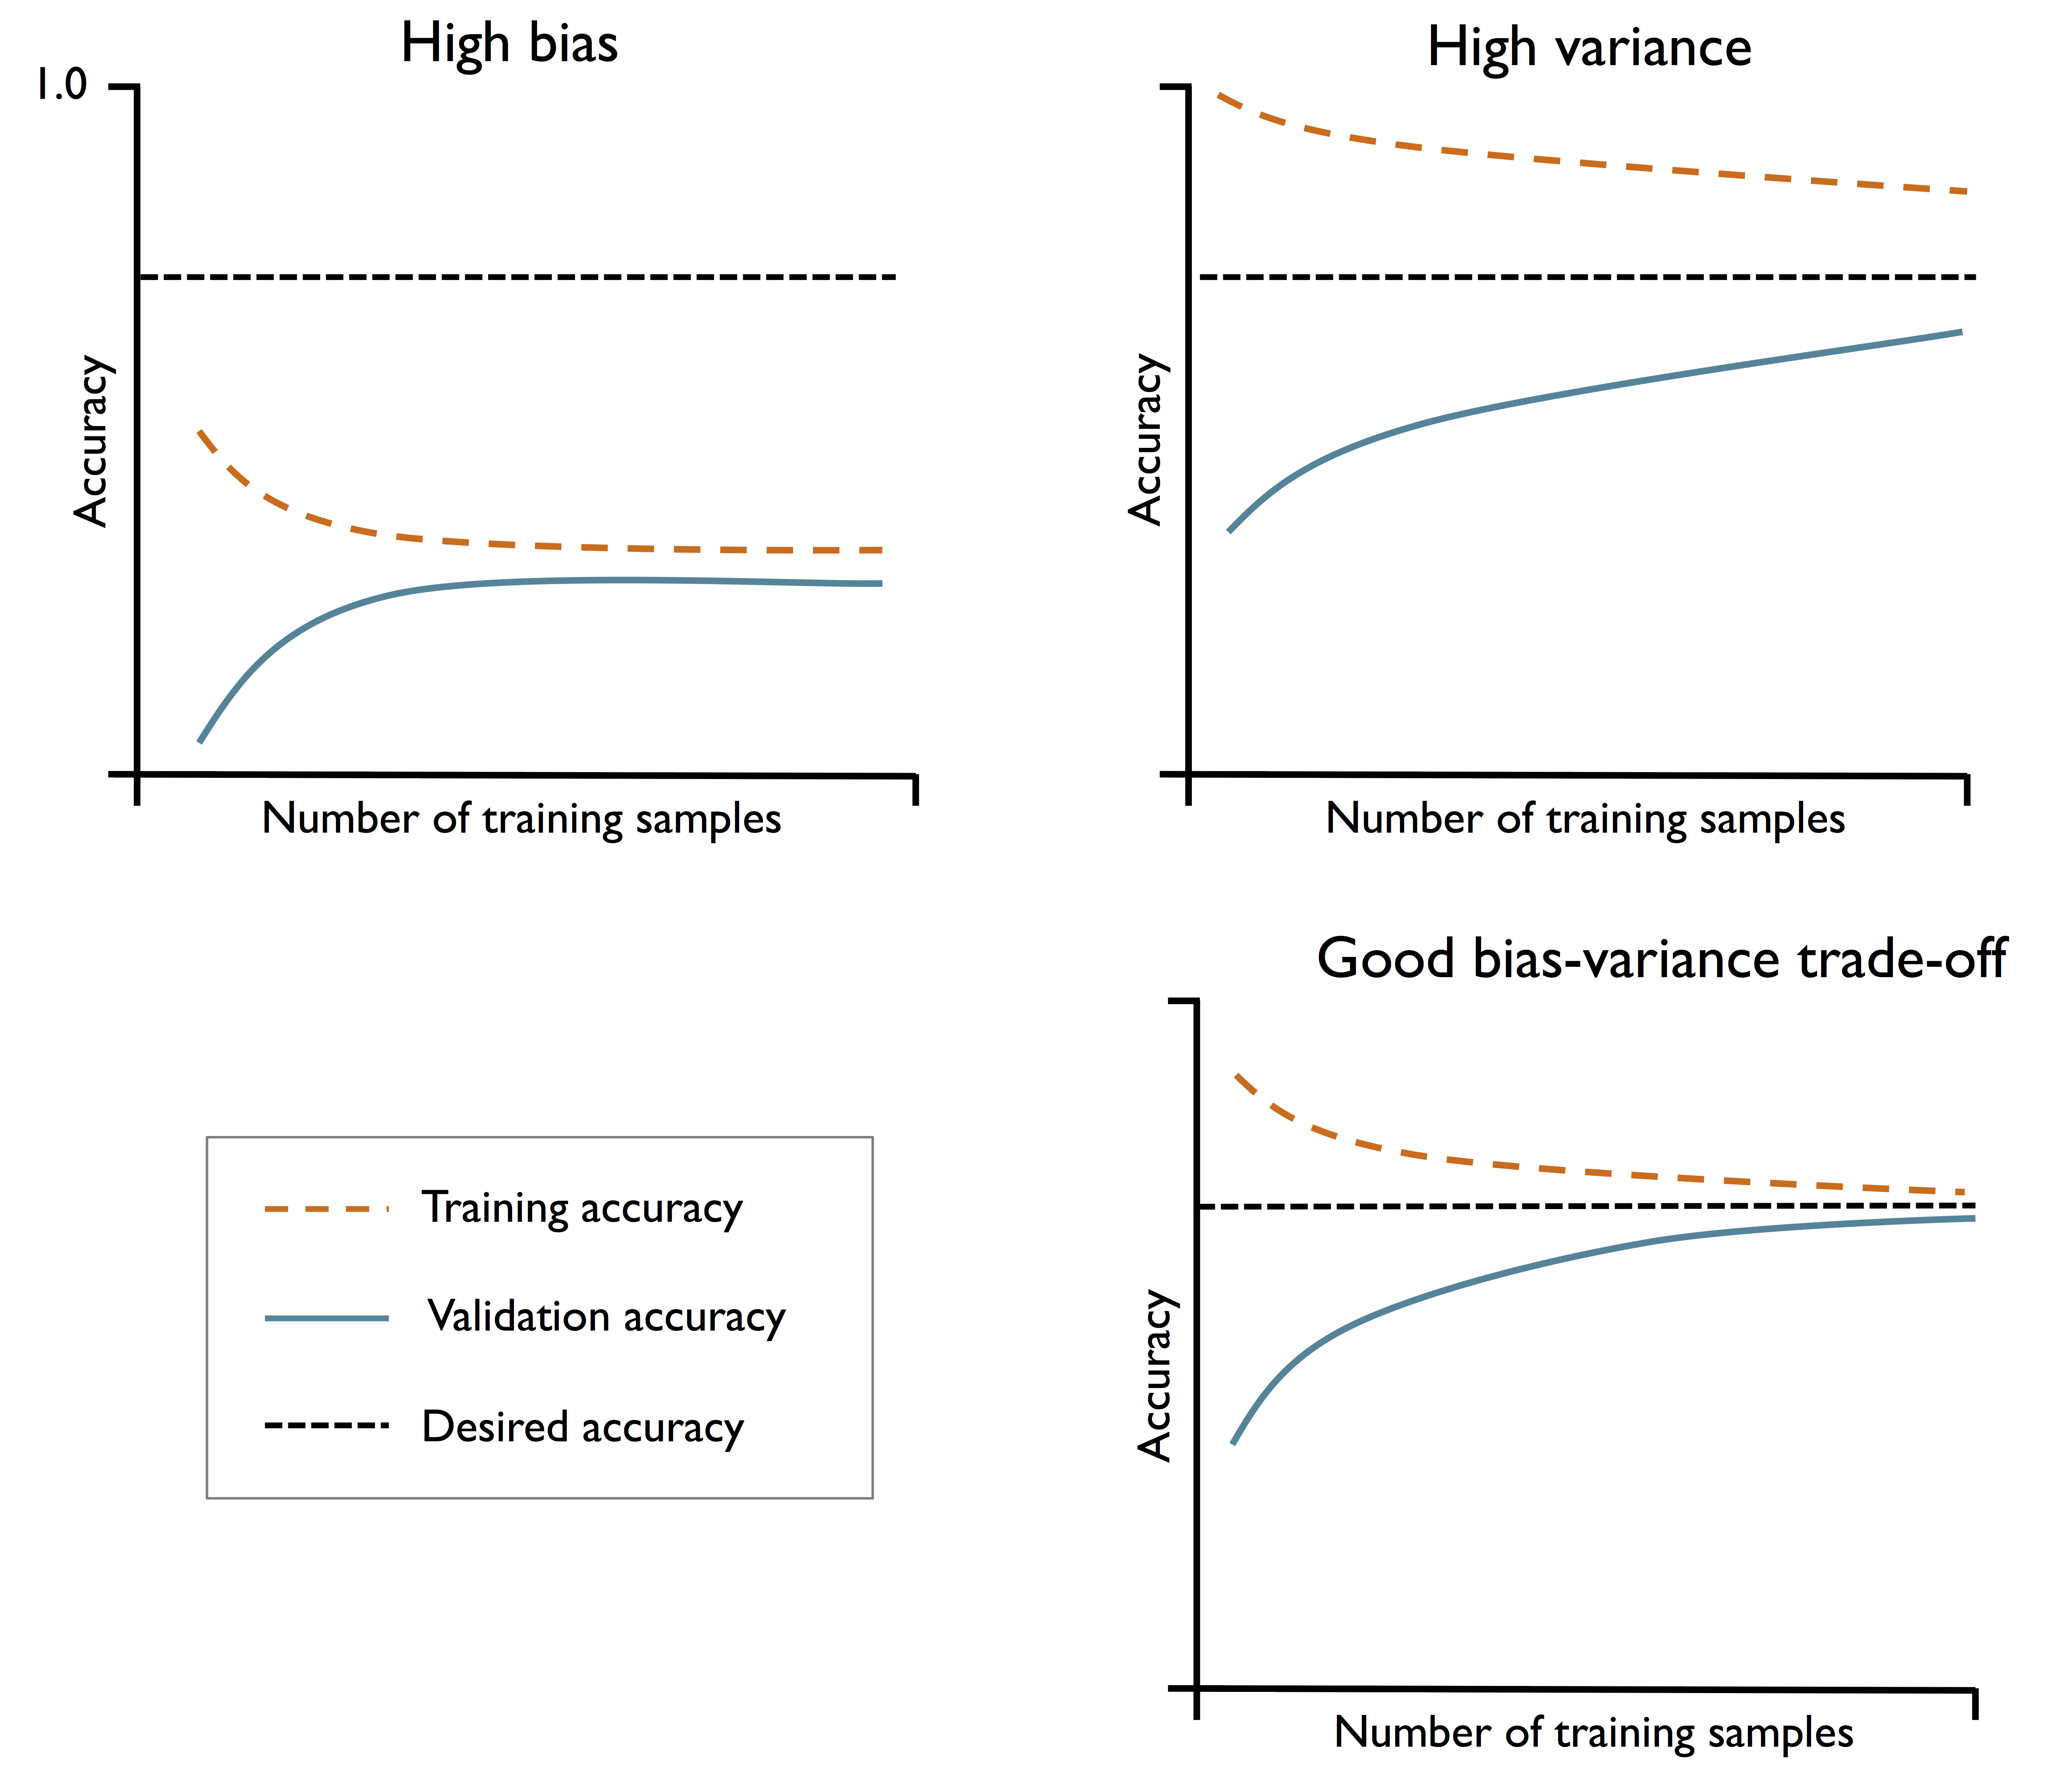

In [50]:
Image(filename='images/svm_fitting.png', width=600) 